for starting point and noise robustness experiments

확인하기 :
1. that’s consistent with the rest of the paper’s setup (161-point fit window, 41 noisy observations, forecasting on the remaining half
2. 지금 코드는 noise sacel 0.1로 동일함. 
3. dropout 설정해야되나???

## log LV

### noise scale 0.1로 통일

In [ ]:
import os, gc, json, csv
import numpy as np
import torch
from scipy.integrate import odeint
from scripts.magix.dynamic import nnMTModule
from scripts.magix.inference import FMAGI

# ───────────────────────────────────────────────────
# 0) Settings (match CODE2)
# ───────────────────────────────────────────────────
torch.set_default_dtype(torch.double)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
torch.set_num_threads(1)

BASE_SEED  = 188714368
NO_TRAIN   = 41
GRID_SIZE  = 161
MAX_EPOCH  = 2500
LR         = 1e-3
DP         = 0.0

tdata      = np.linspace(0, 12, 321)   # 0..12 with 321 points
FIT_END    = 161                       # first 161 = fitting phase (indices 0..160)
obs_idx    = np.linspace(0, int((tdata.size-1)/2), NO_TRAIN).astype(int)
LV_PARAMS  = (1.5, 1.0, 1.0, 3.0)      # (a,b,c,d)

# ───────────────────────────────────────────────────
# 1) Ground-truth LV in (P,D)-space; log-space truth
# ───────────────────────────────────────────────────
def LV(y, t, a, b, c, d):
    P, D = y
    return [a*P - b*P*D, c*P*D - d*D]

def simulate_log_traj(y0):
    traj = odeint(LV, y0, tdata, args=LV_PARAMS)  # (321,2) in linear space
    return np.log(traj)                            # (321,2) in log space

# ───────────────────────────────────────────────────
# 2) Build noisy, subsampled log-space observations
# ───────────────────────────────────────────────────
def build_logspace_obs_from_traj(traj_log, tdata, noise_std, obs_idx, seed):
    rng = np.random.default_rng(seed)
    obs = []
    for d in range(traj_log.shape[1]):
        tobs    = tdata[obs_idx].copy()
        y_true  = traj_log[obs_idx, d].copy()
        y_noisy = y_true + rng.normal(0.0, noise_std[d], size=len(obs_idx))
        obs.append(np.column_stack([tobs, y_noisy]))
    return obs

# ───────────────────────────────────────────────────
# 3) Training + robust reconstruction wrapper
#    (handles different predict() output lengths)
# ───────────────────────────────────────────────────
def train_and_reconstruct(traj_log, noise_std, seed, verbose=False):
    ys = build_logspace_obs_from_traj(traj_log, tdata, noise_std, obs_idx, seed)
    fOde = nnMTModule(2, [512], dp=DP)
    torch.manual_seed(seed)
    model = FMAGI(ys, fOde, grid_size=GRID_SIZE, interpolation_orders=3)

    tinfer, xinfer = model.map(
        max_epoch=MAX_EPOCH,
        learning_rate=LR, decay_learning_rate=True,
        hyperparams_update=False,
        dynamic_standardization=True,
        verbose=verbose, returnX=True
    )

    # Reconstruction horizon aligned to tdata
    trecon = tdata  # length 321
    x0     = xinfer[0, :].squeeze()  # inferred log-state at t0

    # Predict from trecon[1:] given initial trecon[:1] and x0
    tr, xr = model.predict(trecon[1:], trecon[:1], x0, random=False)

    # Robust stitching to match (321,2)
    # Common cases:
    #  - xr.shape[0] == 320 → prepend x0 → 321 rows
    #  - xr.shape[0] == 321 → already full length (rare build)
    if xr.shape[0] == trecon.size - 1:
        x_recon = np.vstack([x0[None, :], xr])
    elif xr.shape[0] == trecon.size:
        x_recon = xr
    else:
        # Fallback: interpolate xr to trecon using provided times
        # We assume 'tr' are the times for xr (len(tr)==xr.shape[0])
        # Build a time/value pair including x0 at trecon[0]
        if xr.ndim != 2 or xr.shape[1] != 2:
            raise RuntimeError(f"Unexpected predict() shape: xr={xr.shape}")
        t_pred = np.concatenate([trecon[:1], tr])
        X_pred = np.vstack([x0[None, :], xr])
        x_recon = np.column_stack([
            np.interp(trecon, t_pred, X_pred[:, 0]),
            np.interp(trecon, t_pred, X_pred[:, 1]),
        ])

    if x_recon.shape != traj_log.shape:
        # As an extra safety-net, resample onto tdata if a tiny off-by-one occurs
        x_recon = np.column_stack([
            np.interp(tdata, trecon, x_recon[:, 0]),
            np.interp(tdata, trecon, x_recon[:, 1]),
        ])
    assert x_recon.shape == traj_log.shape == (tdata.size, 2), \
        f"Shapes differ: recon={x_recon.shape}, true={traj_log.shape}"

    # cleanup
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    return x_recon  # (321,2) in log space

# ───────────────────────────────────────────────────
# 4) RMSE utilities
# ───────────────────────────────────────────────────
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))

def split_rmse(x_recon, x_true):
    fit_slice  = slice(0, FIT_END)     # 0..160
    forc_slice = slice(FIT_END, None)  # 161..320
    return {
        ("fit",  "x1"): rmse(x_recon[fit_slice,  0], x_true[fit_slice,  0]),
        ("fit",  "x2"): rmse(x_recon[fit_slice,  1], x_true[fit_slice,  1]),
        ("forc", "x1"): rmse(x_recon[forc_slice, 0], x_true[forc_slice, 0]),
        ("forc", "x2"): rmse(x_recon[forc_slice, 1], x_true[forc_slice, 1]),
    }

# ───────────────────────────────────────────────────
# 5) Experiment sweeps + saving (JSON/CSV/TEX)
# ───────────────────────────────────────────────────
def robustness_table(
    starts=((3.0,1.0), (4.0,0.5), (5.0,0.2), (7.0,0.1)),
    noise_sigmas=(0.05, 0.10, 0.25),       # σ (std) in log-space
    N_RUNS=10,
    base_seed=BASE_SEED,
    verbose=False,
    outdir="results"
):
    os.makedirs(outdir, exist_ok=True)

    # Store per-run RMSE for reproducibility/plots
    per_run_rows = []  # CSV rows

    # Aggregate for table: dict[(label, phase, comp)] -> list of rmse
    results = {}

    # 5a) Starting-point robustness @ fixed noise σ=0.10
    fixed_noise = [0.10, 0.10]
    for start in starts:
        label = f"Start ({start[0]:.1f},{start[1]:.1f})"
        true_log = simulate_log_traj(start)
        for rep in range(N_RUNS):
            seed = base_seed + 1337*rep + (hash(start) % 997)
            x_recon = train_and_reconstruct(true_log, fixed_noise, seed, verbose=verbose)
            r = split_rmse(x_recon, true_log)
            for phase in ("fit", "forc"):
                for comp in ("x1", "x2"):
                    results.setdefault((label, phase, comp), []).append(r[(phase, comp)])
                    per_run_rows.append({
                        "group": "start",
                        "setting": label,
                        "phase": phase,
                        "component": comp,
                        "seed": seed,
                        "rmse": r[(phase, comp)],
                    })

    # 5b) Noise robustness @ canonical start (5.0, 0.2) with varying σ
    canonical_start = (5.0, 0.2)
    true_log = simulate_log_traj(canonical_start)
    def noise_label(s): return f"Noise $\\sigma = {s:.2f}$"
    for sigma in noise_sigmas:
        noise_std = [sigma, sigma]
        label = noise_label(sigma)
        for rep in range(N_RUNS):
            seed = base_seed + 4242*rep + int(1e3*sigma)
            x_recon = train_and_reconstruct(true_log, noise_std, seed, verbose=verbose)
            r = split_rmse(x_recon, true_log)
            for phase in ("fit", "forc"):
                for comp in ("x1", "x2"):
                    results.setdefault((label, phase, comp), []).append(r[(phase, comp)])
                    per_run_rows.append({
                        "group": "noise",
                        "setting": label,
                        "phase": phase,
                        "component": comp,
                        "seed": seed,
                        "rmse": r[(phase, comp)],
                    })

    # 5c) Save raw results (JSON)
    raw_json = os.path.join(outdir, "fn_robustness_raw.json")
    with open(raw_json, "w") as f:
        # Convert tuple keys to strings for JSON
        json.dump({str(k): v for k, v in results.items()}, f, indent=2)
    print(f"[✓] Saved raw results to {raw_json}")

    # 5d) Save per-run results (CSV)
    raw_csv = os.path.join(outdir, "fn_robustness_runs.csv")
    with open(raw_csv, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["group","setting","phase","component","seed","rmse"])
        w.writeheader()
        w.writerows(per_run_rows)
    print(f"[✓] Saved per-run results to {raw_csv}")

    # 5e) Produce LaTeX table
    def fmt(arr):
        arr = np.asarray(arr, dtype=float)
        return f"{np.mean(arr):.2f} $\\pm$ {np.std(arr):.2f}"

    row_order = [f"Start ({a:.1f},{b:.1f})" for (a,b) in starts] + [noise_label(s) for s in noise_sigmas]

    lines = []
    lines.append("\\begin{tabular}{lcccc}")
    lines.append("\\toprule")
    lines.append(" & \\multicolumn{2}{c}{Fitting RMSE} & \\multicolumn{2}{c}{Forecasting RMSE} \\\\")
    lines.append("\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}")
    lines.append("Setting & $x_1$ & $x_2$ & $x_1$ & $x_2$ \\\\")
    lines.append("\\midrule")
    for label in row_order:
        f_x1 = fmt(results[(label, "fit",  "x1")])
        f_x2 = fmt(results[(label, "fit",  "x2")])
        p_x1 = fmt(results[(label, "forc", "x1")])
        p_x2 = fmt(results[(label, "forc", "x2")])
        lines.append(f"{label} & {f_x1} & {f_x2} & {p_x1} & {p_x2} \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    latex_table = "\n".join(lines)

    tex_path = os.path.join(outdir, "robustness_table.tex")
    with open(tex_path, "w") as f:
        f.write(latex_table)
    print(f"[✓] Saved LaTeX table to {tex_path}")

    # also print for quick copy
    print("\n" + latex_table)

    return results

# ───────────────────────────────────────────────────
# 6) Run (bump N_RUNS=100 for paper)
# ───────────────────────────────────────────────────
if __name__ == "__main__":
    _ = robustness_table(
        starts=((3.0,1.0), (4.0,0.5), (5.0,0.2), (7.0,0.1)),
        noise_sigmas=(0.05, 0.10, 0.25),  # σ (std), not variance
        N_RUNS=5,                         # quick sanity; use 100 for paper
        base_seed=BASE_SEED,
        verbose=True,
        outdir="results"
    )


1/2500 iteration: 133.646339
500/2500 iteration: 4.608244


KeyboardInterrupt: 

### SNR noise scale plotting

[✓] saved results/starting_point_robustness_snr.pdf
[✓] saved results/starting_point_robustness_snr.png


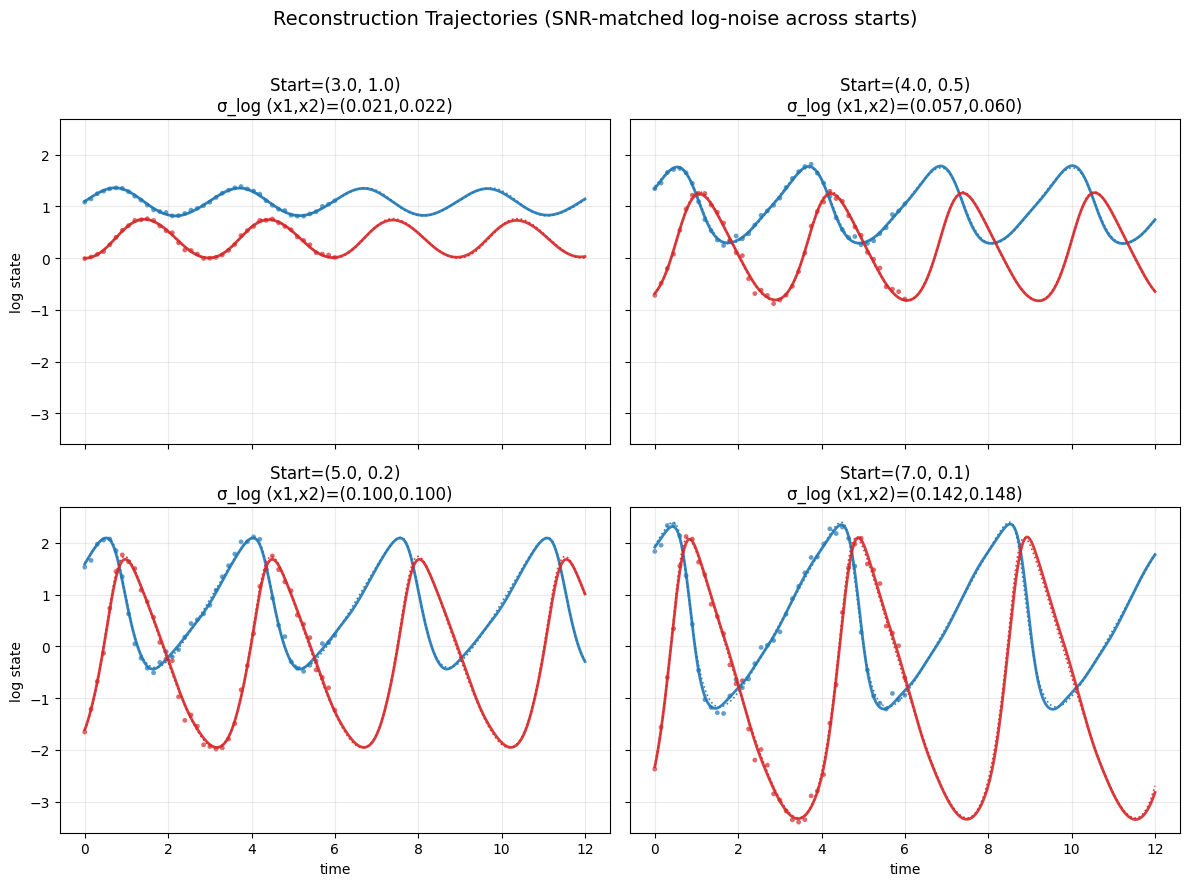

In [7]:
import os, gc, numpy as np, torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scripts.magix.dynamic import nnMTModule
from scripts.magix.inference import FMAGI

# ───────────────────────────────────────────────────
# Settings (your defaults)
# ───────────────────────────────────────────────────
torch.set_default_dtype(torch.double)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
torch.set_num_threads(1)

SEED       = 188714368
NO_TRAIN   = 41
GRID_SIZE  = 161
MAX_EPOCH  = 2500
LR         = 1e-3
DP         = 0.0

tdata      = np.linspace(0, 12, 321)
FIT_END    = 161
obs_idx    = np.linspace(0, int((tdata.size-1)/2), NO_TRAIN).astype(int)
LV_PARAMS  = (1.5, 1.0, 1.0, 3.0)

starts     = [(3.0,1.0), (4.0,0.5), (5.0,0.2), (7.0,0.1)]
baseline   = (5.0, 0.2)             # used to define the target SNR
sigma_base = [0.10, 0.10]           # your original log-space σ for the baseline

# ───────────────────────────────────────────────────
# LV and simulation helpers
# ───────────────────────────────────────────────────
def LV(y, t, a, b, c, d):
    P, D = y
    return [a*P - b*P*D, c*P*D - d*D]

def simulate_log_traj(y0):
    traj = odeint(LV, y0, tdata, args=LV_PARAMS)  # (321,2), linear space
    return np.log(traj)                            # (321,2), log space

# ───────────────────────────────────────────────────
# SNR-calibrated noise (log-space)
# ───────────────────────────────────────────────────
def snr_calibrated_sigmas(traj_log_start, traj_log_baseline, sigma_base, use_fit_window=True):
    """Return per-component σ for 'start' so that σ/std equals baseline σ/std (in log-space)."""
    if use_fit_window:
        s_slice = slice(0, FIT_END)
    else:
        s_slice = slice(None)
    std_base  = np.std(traj_log_baseline[s_slice, :], axis=0) + 1e-12
    std_start = np.std(traj_log_start[s_slice,  :], axis=0) + 1e-12
    rho       = np.asarray(sigma_base) / std_base       # target ratio per component
    return (rho * std_start).tolist()

def build_logspace_obs_from_traj(traj_log, tdata, noise_std, obs_idx, seed):
    rng = np.random.default_rng(seed)
    obs = []
    for d in range(traj_log.shape[1]):
        tobs    = tdata[obs_idx].copy()
        y_true  = traj_log[obs_idx, d].copy()
        y_noisy = y_true + rng.normal(0.0, noise_std[d], size=len(obs_idx))
        obs.append(np.column_stack([tobs, y_noisy]))
    return obs

# ───────────────────────────────────────────────────
# MAGI-X training + robust prediction
# ───────────────────────────────────────────────────
def train_and_predict(traj_log, noise_std, seed, verbose=True):
    ys = build_logspace_obs_from_traj(traj_log, tdata, noise_std, obs_idx, seed)
    fOde = nnMTModule(2, [512], dp=DP)
    torch.manual_seed(seed)
    model = FMAGI(ys, fOde, grid_size=GRID_SIZE, interpolation_orders=3)

    _, xinfer = model.map(
        max_epoch=MAX_EPOCH, learning_rate=LR, decay_learning_rate=True,
        hyperparams_update=False, dynamic_standardization=True,
        verbose=verbose, returnX=True
    )

    # Predict on full horizon; guard against 320/321 issue
    t_all = tdata
    x0    = xinfer[0, :].squeeze()
    tr, xr = model.predict(t_all[1:], t_all[:1], x0, random=False)
    if xr.shape[0] == t_all.size - 1:
        x_recon = np.vstack([x0[None, :], xr])
    elif xr.shape[0] == t_all.size:
        x_recon = xr
    else:
        t_pred = np.concatenate([t_all[:1], tr])
        X_pred = np.vstack([x0[None, :], xr])
        x_recon = np.column_stack([
            np.interp(t_all, t_pred, X_pred[:,0]),
            np.interp(t_all, t_pred, X_pred[:,1]),
        ])

    # cleanup
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    return x_recon

# ───────────────────────────────────────────────────
# Figure with SNR-matched noise across starts
# ───────────────────────────────────────────────────
def plot_starting_point_robustness_SNR(outdir="results"):
    os.makedirs(outdir, exist_ok=True)
    # Precompute baseline std and all true logs
    true_logs = {s: simulate_log_traj(s) for s in starts}
    base_log  = true_logs[baseline]

    # global y-lims across ALL starts/components for fair visual comparison
    ymin = min(np.min(v) for v in true_logs.values())
    ymax = max(np.max(v) for v in true_logs.values())
    pad  = 0.05 * (ymax - ymin)
    ylim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
    axes = axes.ravel()

    colors = ["tab:blue","tab:red"]  # x1, x2

    for ax, s in zip(axes, starts):
        true_log = true_logs[s]
        # SNR-calibrate σ for this start using the baseline ratio
        noise_std = snr_calibrated_sigmas(true_log, base_log, sigma_base, use_fit_window=True)

        # train & reconstruct
        x_recon = train_and_predict(true_log, noise_std, seed=SEED, verbose=False)

        # scatter noisy obs used for training (same seed so reproducible)
        obs = build_logspace_obs_from_traj(true_log, tdata, noise_std, obs_idx, SEED)

        # plot
        for d in range(2):
            ax.plot(tdata, x_recon[:, d], lw=2.0, alpha=0.9, color=colors[d])
            ax.plot(tdata, true_log[:, d], lw=1.2, ls=":", color=colors[d], alpha=0.9)
            ax.scatter(obs[d][:,0], obs[d][:,1], s=12, marker='o', edgecolor='none',
                       color=colors[d], alpha=0.7)
        ax.set_title(f"Start=({s[0]:.1f}, {s[1]:.1f})\nσ_log (x1,x2)=({noise_std[0]:.3f},{noise_std[1]:.3f})")
        ax.set_ylim(*ylim)
        ax.grid(True, alpha=0.25)

    fig.suptitle("Reconstruction Trajectories (SNR-matched log-noise across starts)", y=0.98, fontsize=14)
    for ax in axes[2:]: ax.set_xlabel("time")
    for i in (0,2): axes[i].set_ylabel("log state")
    fig.tight_layout(rect=(0,0,1,0.96))

    pdf_path = os.path.join(outdir, "starting_point_robustness_snr.pdf")
    png_path = os.path.join(outdir, "starting_point_robustness_snr.png")
    fig.savefig(pdf_path, bbox_inches="tight")
    fig.savefig(png_path, dpi=180, bbox_inches="tight")
    print(f"[✓] saved {pdf_path}\n[✓] saved {png_path}")

if __name__ == "__main__":
    plot_starting_point_robustness_SNR(outdir="results")


## FN

In [8]:
import os, gc, json, csv
import numpy as np
import torch
from scipy.integrate import odeint
from scripts.magix.dynamic import nnMTModule
from scripts.magix.inference import FMAGI

# ───────────────────────────────────────────────────
# 0) Settings (match CODE2; now for FN)
# ───────────────────────────────────────────────────
torch.set_default_dtype(torch.double)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
torch.set_num_threads(1)

BASE_SEED  = 188714368
NO_TRAIN   = 41
GRID_SIZE  = 161
MAX_EPOCH  = 2500
LR         = 1e-3
DP         = 0.0

# FN uses a longer horizon (0..40) while keeping 321 points like before
tdata      = np.linspace(0, 40, 321)   # 0..40 with 321 points (FN)
FIT_END    = 161                       # first 161 = fitting phase (indices 0..160)
obs_idx    = np.linspace(0, int((tdata.size-1)/2), NO_TRAIN).astype(int)

# FN parameters and canonical start
FN_PARAMS  = (0.2, 0.2, 3.0)           # (a, b, c)
FN_START   = (-1.0, 1.0)               # default x(0) used in many references

# ───────────────────────────────────────────────────
# 1) Ground-truth FitzHugh–Nagumo in native space
# ───────────────────────────────────────────────────
def FN(y, t, a, b, c):
    v, r = y
    dvdt = c * (v - (v**3)/3.0 + r)
    drdt = -(v - a + b*r) / c
    return [dvdt, drdt]

def simulate_fn_traj(y0):
    # returns (321,2) in native FN space (no log)
    return odeint(FN, y0, tdata, args=FN_PARAMS)

# ───────────────────────────────────────────────────
# 2) Noisy, subsampled observations in native space
# ───────────────────────────────────────────────────
def build_obs_from_traj(traj, tdata, noise_std, obs_idx, seed):
    rng = np.random.default_rng(seed)
    obs = []
    for d in range(traj.shape[1]):
        tobs    = tdata[obs_idx].copy()
        y_true  = traj[obs_idx, d].copy()
        y_noisy = y_true + rng.normal(0.0, noise_std[d], size=len(obs_idx))
        obs.append(np.column_stack([tobs, y_noisy]))
    return obs

# ───────────────────────────────────────────────────
# 3) Training + robust reconstruction wrapper
#    (handles different predict() output lengths)
# ───────────────────────────────────────────────────
def train_and_reconstruct(traj_true, noise_std, seed, verbose=False):
    ys = build_obs_from_traj(traj_true, tdata, noise_std, obs_idx, seed)
    fOde = nnMTModule(2, [512], dp=DP)
    torch.manual_seed(seed)
    model = FMAGI(ys, fOde, grid_size=GRID_SIZE, interpolation_orders=3)

    tinfer, xinfer = model.map(
        max_epoch=MAX_EPOCH,
        learning_rate=LR, decay_learning_rate=True,
        hyperparams_update=False,
        dynamic_standardization=True,
        verbose=verbose, returnX=True
    )

    # Reconstruction horizon aligned to tdata
    trecon = tdata  # length 321
    x0     = xinfer[0, :].squeeze()  # inferred state at t0

    # Predict from trecon[1:] given initial trecon[:1] and x0
    tr, xr = model.predict(trecon[1:], trecon[:1], x0, random=False)

    # Robust stitching to match (321,2)
    if xr.shape[0] == trecon.size - 1:
        x_recon = np.vstack([x0[None, :], xr])
    elif xr.shape[0] == trecon.size:
        x_recon = xr
    else:
        if xr.ndim != 2 or xr.shape[1] != 2:
            raise RuntimeError(f"Unexpected predict() shape: xr={xr.shape}")
        t_pred = np.concatenate([trecon[:1], tr])
        X_pred = np.vstack([x0[None, :], xr])
        x_recon = np.column_stack([
            np.interp(trecon, t_pred, X_pred[:, 0]),
            np.interp(trecon, t_pred, X_pred[:, 1]),
        ])

    if x_recon.shape != traj_true.shape:
        x_recon = np.column_stack([
            np.interp(tdata, trecon, x_recon[:, 0]),
            np.interp(tdata, trecon, x_recon[:, 1]),
        ])
    assert x_recon.shape == traj_true.shape == (tdata.size, 2), \
        f"Shapes differ: recon={x_recon.shape}, true={traj_true.shape}"

    # cleanup
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    return x_recon  # (321,2) in native FN space

# ───────────────────────────────────────────────────
# 4) RMSE utilities
# ───────────────────────────────────────────────────
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))

def split_rmse(x_recon, x_true):
    fit_slice  = slice(0, FIT_END)     # 0..160
    forc_slice = slice(FIT_END, None)  # 161..320
    return {
        ("fit",  "x1"): rmse(x_recon[fit_slice,  0], x_true[fit_slice,  0]),
        ("fit",  "x2"): rmse(x_recon[fit_slice,  1], x_true[fit_slice,  1]),
        ("forc", "x1"): rmse(x_recon[forc_slice, 0], x_true[forc_slice, 0]),
        ("forc", "x2"): rmse(x_recon[forc_slice, 1], x_true[forc_slice, 1]),
    }

# ───────────────────────────────────────────────────
# 5) Experiment sweeps + saving (JSON/CSV/TEX)
# ───────────────────────────────────────────────────
def robustness_table(
    starts=((-1.0, 1.0), (-0.5, 0.5), (0.0, 0.8), (0.8, -0.2)),  # FN-friendly starts
    noise_sigmas=(0.05, 0.10, 0.25),       # σ (std) in native FN units
    N_RUNS=10,
    base_seed=BASE_SEED,
    verbose=False,
    outdir="results"
):
    os.makedirs(outdir, exist_ok=True)

    per_run_rows = []  # CSV rows
    results = {}       # dict[(label, phase, comp)] -> list of rmse

    # 5a) Starting-point robustness @ fixed noise σ=0.10
    fixed_noise = [0.10, 0.10]
    for start in starts:
        label = f"Start ({start[0]:.1f},{start[1]:.1f})"
        true = simulate_fn_traj(start)
        for rep in range(N_RUNS):
            seed = base_seed + 1337*rep + (hash(start) % 997)
            x_recon = train_and_reconstruct(true, fixed_noise, seed, verbose=verbose)
            r = split_rmse(x_recon, true)
            for phase in ("fit", "forc"):
                for comp in ("x1", "x2"):
                    results.setdefault((label, phase, comp), []).append(r[(phase, comp)])
                    per_run_rows.append({
                        "group": "start",
                        "setting": label,
                        "phase": phase,
                        "component": comp,
                        "seed": seed,
                        "rmse": r[(phase, comp)],
                    })

    # 5b) Noise robustness @ canonical FN start
    canonical_start = FN_START
    true = simulate_fn_traj(canonical_start)
    def noise_label(s): return f"Noise $\\sigma = {s:.2f}$"
    for sigma in noise_sigmas:
        noise_std = [sigma, sigma]
        label = noise_label(sigma)
        for rep in range(N_RUNS):
            seed = base_seed + 4242*rep + int(1e3*sigma)
            x_recon = train_and_reconstruct(true, noise_std, seed, verbose=verbose)
            r = split_rmse(x_recon, true)
            for phase in ("fit", "forc"):
                for comp in ("x1", "x2"):
                    results.setdefault((label, phase, comp), []).append(r[(phase, comp)])
                    per_run_rows.append({
                        "group": "noise",
                        "setting": label,
                        "phase": phase,
                        "component": comp,
                        "seed": seed,
                        "rmse": r[(phase, comp)],
                    })

    # 5c) Save raw results (JSON)
    raw_json = os.path.join(outdir, "robustness_raw.json")
    with open(raw_json, "w") as f:
        json.dump({str(k): v for k, v in results.items()}, f, indent=2)
    print(f"[✓] Saved raw results to {raw_json}")

    # 5d) Save per-run results (CSV)
    raw_csv = os.path.join(outdir, "robustness_runs.csv")
    with open(raw_csv, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["group","setting","phase","component","seed","rmse"])
        w.writeheader()
        w.writerows(per_run_rows)
    print(f"[✓] Saved per-run results to {raw_csv}")

    # 5e) Produce LaTeX table
    def fmt(arr):
        arr = np.asarray(arr, dtype=float)
        return f"{np.mean(arr):.2f} $\\pm$ {np.std(arr):.2f}"

    row_order = [f"Start ({a:.1f},{b:.1f})" for (a,b) in starts] + [noise_label(s) for s in noise_sigmas]

    lines = []
    lines.append("\\begin{tabular}{lcccc}")
    lines.append("\\toprule")
    lines.append(" & \\multicolumn{2}{c}{Fitting RMSE} & \\multicolumn{2}{c}{Forecasting RMSE} \\\\")
    lines.append("\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}")
    lines.append("Setting & $x_1$ & $x_2$ & $x_1$ & $x_2$ \\\\")
    lines.append("\\midrule")
    for label in row_order:
        f_x1 = fmt(results[(label, "fit",  "x1")])
        f_x2 = fmt(results[(label, "fit",  "x2")])
        p_x1 = fmt(results[(label, "forc", "x1")])
        p_x2 = fmt(results[(label, "forc", "x2")])
        lines.append(f"{label} & {f_x1} & {f_x2} & {p_x1} & {p_x2} \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    latex_table = "\n".join(lines)

    tex_path = os.path.join(outdir, "fn_robustness_table.tex")
    with open(tex_path, "w") as f:
        f.write(latex_table)
    print(f"[✓] Saved LaTeX table to {tex_path}")

    # also print for quick copy
    print("\n" + latex_table)

    return results

# ───────────────────────────────────────────────────
# 6) Run (bump N_RUNS=100 for paper)
# ───────────────────────────────────────────────────
if __name__ == "__main__":
    _ = robustness_table(
        starts=((-1.0, 1.0), (-0.5, 0.5), (0.0, 0.8), (0.8, -0.2)),  # adjust as desired
        noise_sigmas=(0.05, 0.10, 0.25),
        N_RUNS=5,                         # quick sanity; use 100 for paper
        base_seed=BASE_SEED,
        verbose=True,
        outdir="results"
    )


1/2500 iteration: 48.632054
500/2500 iteration: 1.977445
1000/2500 iteration: 1.144783
1500/2500 iteration: 1.003626
2000/2500 iteration: 0.957726
2500/2500 iteration: 0.934701
1/2500 iteration: 35.944508
500/2500 iteration: 1.482035
1000/2500 iteration: 1.031106
1500/2500 iteration: 0.962568
2000/2500 iteration: 0.936132
2500/2500 iteration: 0.921701
1/2500 iteration: 44.054562
500/2500 iteration: 1.978314
1000/2500 iteration: 1.311950
1500/2500 iteration: 1.180187
2000/2500 iteration: 1.134194
2500/2500 iteration: 1.110012
1/2500 iteration: 30.274876
500/2500 iteration: 1.494069
1000/2500 iteration: 1.082515
1500/2500 iteration: 0.996323
2000/2500 iteration: 0.958276
2500/2500 iteration: 0.935762
1/2500 iteration: 39.263411
500/2500 iteration: 1.858818
1000/2500 iteration: 1.274692
1500/2500 iteration: 1.153848
2000/2500 iteration: 1.106827
2500/2500 iteration: 1.084966
1/2500 iteration: 31.050195
500/2500 iteration: 2.195825
1000/2500 iteration: 1.636142
1500/2500 iteration: 1.49904

## Hes1